# Importing libraries

First of all, we need to import some external libraries and our own helper files:

In [17]:
print("Importing libraries")
# system libraries
import os
import logging

# third party libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Own helper files
from ml_webinar import preprocessing, evaluate, plots

logging.basicConfig(level=logging.INFO)
print("Done!")

Importing libraries
Done!


# File input

Next, we indicate where our data can be found, several variables for the algorithm, and the correct labels for our data.

In [18]:
DATA_FOLDER = 'data/data_rotation_orig1'
EPOCHS = 5
IMG_PIX = 256
CLASS_DICT = {
    "F": {"index": 0, 'name': "Front"},
    "B": {"index": 1, 'name': "Back"}, 
    "R": {"index": 2, 'name': "Right"},
    "L": {"index": 3, 'name': "Left"},
    "FR": {"index": 4, 'name': "Front Right"},
    "FL": {"index": 5, 'name': "Front Left"},
}

SEED = 1234
np.random.seed(seed=SEED)
tf.random.set_seed(SEED)


# Creating a training set and test set

The pictures in the dataset need to be reformatted before they can be used: we rescale the pixel values, indicate we want the RGB color model, and assign the images to either the training set or test set.

In [19]:
def make_generator(phase):
    image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    return image_gen.flow_from_directory(directory=os.path.join(DATA_FOLDER, phase),
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(IMG_PIX, IMG_PIX),
                                                     classes=list(CLASS_DICT.keys()),
                                                     class_mode='sparse',
                                                     color_mode="rgb",
                                                     seed=SEED
                                                    )

Executing this function for the test set and training set shows us how many images end up in each set.

In [20]:
train_data_gen = make_generator('train')
test_data_gen = make_generator('test')

Found 284 images belonging to 6 classes.
Found 76 images belonging to 6 classes.


# Building the model

Once the data preparation is done, we can start building the model. In this example, we use a simple Neural Network with only three middle layers.

In [21]:
dense_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_PIX, IMG_PIX, 3), name='flatten'),
    keras.layers.Dense(64, activation='relu', name='fc1'),
    keras.layers.Dense(len(CLASS_DICT.keys()), name='fc2'),
])

print("Compiling the model")
dense_model.compile(optimizer='adam', 
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                 metrics=['accuracy'])
print("Done!")

Compiling the model
Done!


We can ask TensorFlow to give us some more information about the model we just created. In the webinar, however, we already show this in the slides.

In [22]:
#dense_model.summary()
#keras.utils.plot_model(dense_model, to_file='reports/model_1.png', show_shapes=True)

# Training the model

Now, we are finally at the point where we can feed the model data to teach it to classify our images correctly.

In [23]:
dense_model.fit(train_data_gen, epochs=EPOCHS)

Epoch 1/5
9/9 [==============================] - 2s 225ms/step - loss: 89.8282 - accuracy: 0.1585
Epoch 2/5
9/9 [==============================] - 2s 205ms/step - loss: 61.2638 - accuracy: 0.2289
Epoch 3/5
9/9 [==============================] - 2s 208ms/step - loss: 15.0422 - accuracy: 0.2887
Epoch 4/5
9/9 [==============================] - 2s 194ms/step - loss: 6.6795 - accuracy: 0.4366
Epoch 5/5
9/9 [==============================] - 2s 189ms/step - loss: 3.5806 - accuracy: 0.5387


After we let the model train on the training data several times, we can add the final output layer which allows us to make easier predictions:

In [24]:
probability_model = tf.keras.Sequential([dense_model, tf.keras.layers.Softmax()])

Just like before, we can ask TensorFlow to give us some more information about the (now trained) model. This can be useful for debugging, but is irrelevant for the webinar demo. 

In [25]:
#keras.utils.plot_model(probability_model, to_file='reports/model_1prob.png', show_shapes=True)

Now that we have a trained model, we can see how well the model performs when we make it pretend the training set is the test set. This allows us to discover problems such as overfitting.

In [26]:
train_images, train_labels = evaluate.get_images('train', DATA_FOLDER, CLASS_DICT, IMG_PIX)
insample_classification = probability_model.predict(train_images)
df_confusion_train = evaluate.make_confusion_matrix(train_labels, insample_classification, CLASS_DICT)
df_confusion_train

INFO:root:284 images in data/data_rotation_orig1\train folder


predicted,Front,Back,Right,Left,Front Right,Front Left
actual,,,,,,
Front,41,2,1,2,0,2
Back,6,30,1,3,0,9
Right,3,3,18,16,0,5
Left,0,4,2,37,0,5
Front Right,16,5,23,4,2,0
Front Left,0,2,0,2,0,40


The classification performance a model gets on the data that is used to train the model is called the train accuracy:

In [27]:
train_accuracy = evaluate.get_accuracy(df_confusion_train)
print(' train accuracy %3.2f' % train_accuracy)

 train accuracy 0.59


# Making predictions

With all the training out of the way, we can feed the Neural Network test data. The algorithm has not seen these images before, but it can use the correct labels to determine the overall accuracy of its predictions.

In [28]:
dense_model.evaluate(test_data_gen)
test_images, test_labels = evaluate.get_images('test', DATA_FOLDER, CLASS_DICT, IMG_PIX)
predictions = probability_model.predict(test_images)

df_confusion_test = evaluate.make_confusion_matrix(test_labels, predictions, CLASS_DICT)
df_confusion_test

3/3 [==============================] - 0s 120ms/step - loss: 6.4721 - accuracy: 0.4079


INFO:root:76 images in data/data_rotation_orig1\test folder


predicted,Front,Back,Right,Left,Front Right,Front Left
actual,,,,,,
Front,5,2,2,1,0,2
Back,6,1,1,2,0,1
Right,3,2,6,4,0,0
Left,0,1,1,7,0,3
Front Right,2,3,3,2,0,0
Front Left,0,1,1,2,0,12


The classification performance a model gets on the test set data is called the test accuracy:

In [29]:
test_accuracy = evaluate.get_accuracy(df_confusion_test)
print(' test accuracy %3.2f' % test_accuracy)

 test accuracy 0.41


# Graphing the predictions

Decimal numbers showing the train and test accuracy are great, but only tell a small part of our model's story. When we plot some or even all predictions together with the corresponding image, we can see which mistakes our model still makes. 

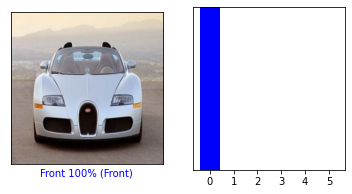

In [30]:
from random import randrange
idx_img = randrange(len(predictions))
plots.plot_image_and_predictions(test_images[idx_img], test_labels[idx_img], predictions[idx_img], CLASS_DICT)

In the plot below, Blue means a correct prediction, and Red means an incorrect prediction. The label below each image shows what the model predicted, and what the actual label is. Can you spot some improvements we can make to the model or dataset?

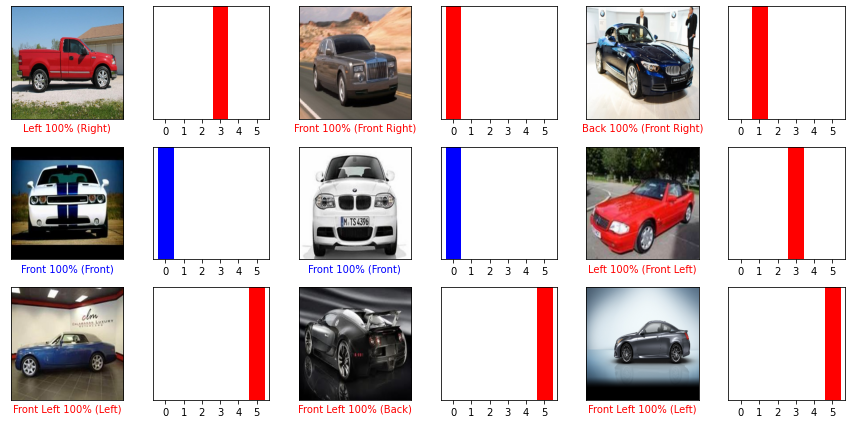

In [31]:
plots.plot_multiple_images_and_predictions(predictions, test_labels, test_images, CLASS_DICT)

# Acknowledgements

In [32]:
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.